In [124]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

In [69]:
#Read the data and drop invalide entries indicated by the value -99.99
co2_df = pd.read_csv('./release_time_series_report_data/CO2.csv', skiprows=57, usecols=[0,1,3,4], names=['Year','Month','Date','CO2'])
co2_df['Period'] = co2_df['Date']-1958
co2_df = co2_df[co2_df['CO2']!=-99.99]


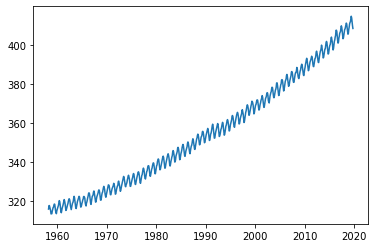

In [6]:
#Plot the data set
plt.plot(co2_df['Date'],co2_df['CO2'])

In [7]:
#Looks like seasonal variation, with increasing trend but not necessarily linear trend (maybe linear after a log tranform)

In [8]:
#Set the training split and get the count of training data points.
train_pct = 0.80
train_count = int(co2_df.shape[0] * train_pct)

#Split the data set into training and test sets
X_train = [[Period] for Period in co2_df['Period'][:train_count]]
Y_train = [[CO2] for CO2 in co2_df['CO2'][:train_count]]
X_test = [[Period] for Period in co2_df['Period'][train_count:]]
Y_test = [[CO2] for CO2 in co2_df['CO2'][train_count:]]

In [9]:
reg = LinearRegression().fit(X_train,Y_train) 
#reg.score(X_train,Y_train)
print("Slope: ", reg.coef_, " Intercept:", reg.intercept_)

Slope:  [[1.40668098]]  Intercept: [308.99546949]


In [10]:
Y_train_predict = reg.predict(X_train)
#Calculate the residuals, defined as the actual value - the predicted
Y_train_residuals = Y_train - Y_train_predict

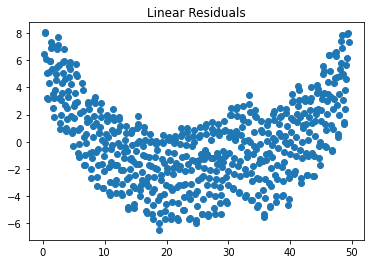

In [11]:
#Plot the residuals
plt.title("Linear Residuals")
plt.scatter(X_train, Y_train_residuals)

In [12]:
#Now predict values for the test set
Y_test_predict = reg.predict(X_test)

#Calculate the root means squared error and the mean absolute pct error 
RMSE = mean_squared_error(Y_test, Y_test_predict, squared=False)
MAPE = mean_absolute_percentage_error(Y_test, Y_test_predict)
print("RMSE: ", RMSE, " MAPE: ", MAPE)

RMSE:  10.642011413148976  MAPE:  0.024505275995447513


In [13]:
#Given the shape of the residuals and the poor RMSE and MAPE results from the linear model, lets try a quadratic model
#PolynomialFeatures and the make_pipeline should help simplify the process
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [14]:
#Start with a quadratic model (2nd order) and then fit it 
degree=2
quadreg=PolynomialFeatures(degree)
X_train_quad = quadreg.fit_transform(X_train)

linreg = LinearRegression()
linreg.fit(X_train_quad, Y_train)

Y_quad_predict = linreg.predict(X_train_quad)

#Print our fitted quadratic coefficients and intercept
print("Coefs: ", linreg.coef_, " Intercept: ", linreg.intercept_)

Coefs:  [[0.         0.80213511 0.01211779]]  Intercept:  [314.10295065]


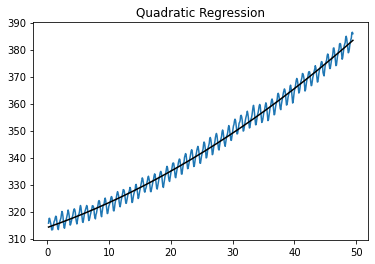

In [15]:
#Let's plot the fitted quadratic model
plt.figure()
plt.plot(X_train,Y_train)
plt.plot(X_train,Y_quad_predict,color="black")
plt.title("Quadratic Regression")
plt.show()

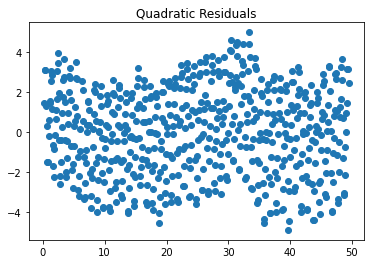

In [16]:
#Now lets calculate and look at the residuals for the quadratic model
quad_train_residuals = Y_train - Y_quad_predict
plt.title("Quadratic Residuals")
plt.scatter(X_train, quad_train_residuals)

In [17]:
#Now predict quadratic values for the transformed test set
X_test_quad = quadreg.transform(X_test)
Y_test_quad_predict = linreg.predict(X_test_quad)

#Calculate our coefficients, the RMSE and MASE
Quad_RMSE = mean_squared_error(Y_test, Y_test_quad_predict, squared=False)
Quad_MAPE = mean_absolute_percentage_error(Y_test, Y_test_quad_predict)
print("Quadratic RMSE: ", Quad_RMSE, " Quadratic MAPE: ", Quad_MAPE)

Quadratic RMSE:  2.5028073719222728  Quadratic MAPE:  0.005322789167375787


In [18]:
#Next try a cubic model (2nd order) and then fit it 
degree = 3
cubereg = PolynomialFeatures(degree)
X_train_cube = cubereg.fit_transform(X_train)

linreg2 = LinearRegression()
linreg2.fit(X_train_cube, Y_train)

Y_cube_predict = linreg2.predict(X_train_cube)

#Print our cubic fitted coefficients and intercept:
print("Coefs: ", linreg2.coef_, " Intercept: ", linreg2.intercept_)

Coefs:  [[ 0.00000000e+00  6.24869938e-01  2.09624454e-02 -1.18397534e-04]]  Intercept:  [314.86089144]


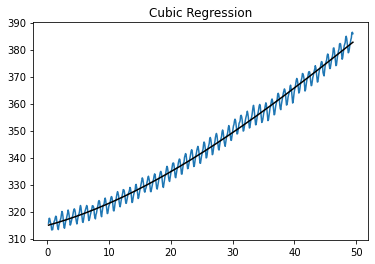

In [19]:
#Let's plot the fitted cubic model
plt.figure()
plt.plot(X_train,Y_train)
plt.plot(X_train,Y_cube_predict,color="black")
plt.title("Cubic Regression")
plt.show()

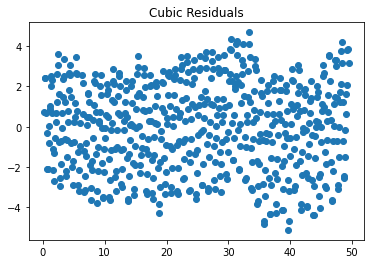

In [20]:
#Now lets calculate and look at the residuals for the quadratic model
cube_train_residuals = Y_train - Y_cube_predict
plt.title("Cubic Residuals")
plt.scatter(X_train, cube_train_residuals)

In [21]:
#Now predict quadratic values for the transformed test set
X_test_cube = cubereg.transform(X_test)
Y_test_cube_predict = linreg2.predict(X_test_cube)

#Calculate our coefficients, the RMSE and MASE
Cube_RMSE = mean_squared_error(Y_test, Y_test_cube_predict, squared=False)
Cube_MAPE = mean_absolute_percentage_error(Y_test, Y_test_cube_predict)
print("Cubic RMSE: ", Cube_RMSE, " Cubic MAPE: ", Cube_MAPE)

Cubic RMSE:  4.151525341775371  Cubic MAPE:  0.00848734285315907


In [73]:

#To assess seasonality, we average the residuals for each monthly period
JanIdx = np.where(co2_df['Month'][:train_count]==1)[0]
FebIdx = np.where(co2_df['Month'][:train_count]==2)[0]

JanAvgRes = np.mean(quad_train_residuals[JanIdx])
FebAvgRes = np.mean(quad_train_residuals[FebIdx])

print('January average residual:', JanAvgRes, 'February average residual:', FebAvgRes)

#quad_train_residuals


January average residual: -0.01564690643915142 February average residual: 0.6414997031065065


In [1]:
# Pricing Data



In [95]:
#Read the datafile 
#set the datetype for datetime

price_df = pd.read_csv('./release_time_series_report_data/PriceStats_CPI.csv', header=0)
price_df['date'] = pd.to_datetime(price_df['date'])
price_df.head

<bound method NDFrame.head of            date  PriceStats    CPI
0    2008-07-24   100.00000  100.0
1    2008-07-25    99.99767  100.0
2    2008-07-26    99.92376  100.0
3    2008-07-27    99.91537  100.0
4    2008-07-28    99.89491  100.0
...         ...         ...    ...
4117 2019-11-01   118.30850    NaN
4118 2019-11-02   118.30440    NaN
4119 2019-11-03   118.31480    NaN
4120 2019-11-04   118.30910    NaN
4121 2019-11-05   118.31170    NaN

[4122 rows x 3 columns]>

In [110]:
#Reduce the series to use only the first day of the month (monthly CPI)
#Validate the expected number of rows of date (1 + 11 years * 12 months + 4 partial year months)
price_monthly_df = price_df[(price_df['date'].dt.day==1) | (price_df['date']=='2008-07-24')]
price_monthly_df.head

<bound method NDFrame.head of            date  PriceStats        CPI
0    2008-07-24   100.00000  100.00000
8    2008-08-01    99.85761  100.52510
39   2008-09-01    99.65436  100.12380
69   2008-10-01    99.72428   99.98538
100  2008-11-01    97.99059   98.97539
...         ...         ...        ...
3994 2019-07-01   117.78350  117.05920
4025 2019-08-01   117.94860  117.25480
4056 2019-09-01   117.84700  117.24880
4086 2019-10-01   118.18270  117.34070
4117 2019-11-01   118.30850        NaN

[137 rows x 3 columns]>

<function matplotlib.pyplot.show(close=None, block=None)>

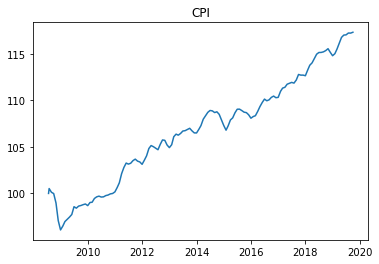

In [111]:
#Plot the data set
plt.title('CPI')
plt.plot(price_monthly_df['date'],price_monthly_df['CPI'])
plt.show

In [114]:
#Filter to values before September 2013
price_monthly_df_train = price_monthly_df[price_monthly_df['date'] < '2013-09-01']

#Reindex the date to monthly periods starting August 2008
#Reshape the data to numpy arrays for sklearn
X_train_cpi = ((price_monthly_df_train['date'].dt.year - 2008)*12 + price_monthly_df_train['date'].dt.month - 8).values.reshape(-1,1)
Y_train_cpi = price_monthly_df_train['CPI'].values.reshape(-1,1)

#Train a linear regressor on dates before September 2013
reg_cpi = LinearRegression().fit(X_train_cpi, Y_train_cpi) 
#reg.score(X_train,Y_train)
print("CPI Slope: ", reg_cpi.coef_, " CPI Intercept:", reg_cpi.intercept_)


CPI Slope:  [[0.16104348]]  CPI Intercept: [96.89036981]


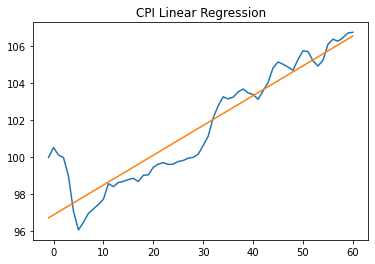

In [130]:
#Get the linear trend predicted values 
Y_predict_cpi = reg_cpi.predict(X_train_cpi)

plt.title('CPI Linear Regression')
plt.plot(X_train_cpi, Y_train_cpi)
plt.plot(X_train_cpi, Y_predict_cpi)

Maximum absolute value of CPI residuals:  3.63473018760547


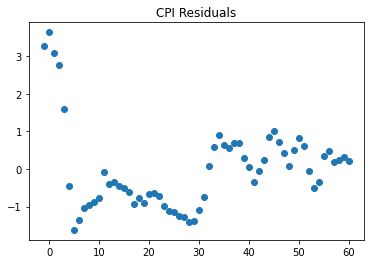

In [131]:
#Subtract these from the actual CPI to get the residual values
Residuals_cpi = Y_train_cpi - Y_predict_cpi

#Plot the residuals
plt.title("CPI Residuals")
plt.scatter(X_train_cpi, Residuals_cpi)

#Print the maximum absolute value
print('Maximum absolute value of CPI residuals: ', np.max(np.abs(Residuals_cpi)))

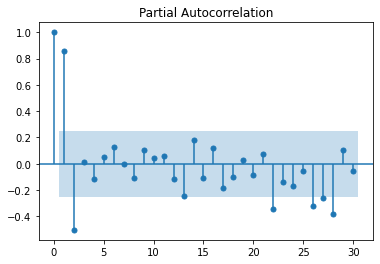

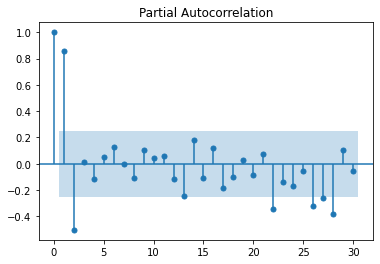

In [127]:
#Plot the Partial Autocorrelation Function of the detrended residuals
#Below we find the first two terms are significant, but those beyond that only show small amounts of noise
sm.graphics.tsa.plot_pacf(Residuals_cpi.squeeze(), lags=30)

In [146]:
#Fit a 2 degree autoregressive model on the residual CPI data
auto_reg_detrend = AutoReg(Residuals_cpi, lags=2, trend='n', old_names=False).fit()

#Print the fitted AR model parameters
print('Phi 0: ', auto_reg_detrend.params[0], 'Phi 1: ',  auto_reg_detrend.params[1])

Phi 0:  1.3355458979064994 Phi 1:  -0.5405672099254746


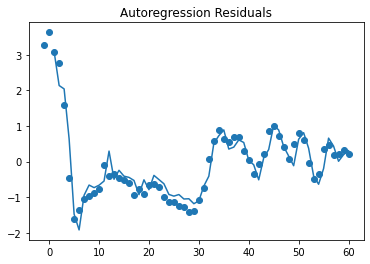

In [160]:
Y_train_autoreg = auto_reg_detrend.predict().reshape(-1,1)

#Plot the residuals
plt.title("Autoregression Residuals")
plt.scatter(X_train_cpi, Residuals_cpi)
plt.plot(X_train_cpi[2:], Y_train_autoreg)

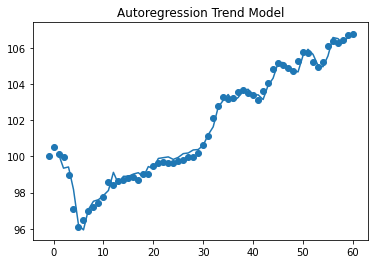

In [162]:
#Plot the AR and Trend Model
Y_train_ART = Y_train_autoreg + Y_predict_cpi[2:]

plt.title("Autoregression Trend Model")
plt.scatter(X_train_cpi, Y_train_cpi)
plt.plot(X_train_cpi[2:], Y_train_ART)

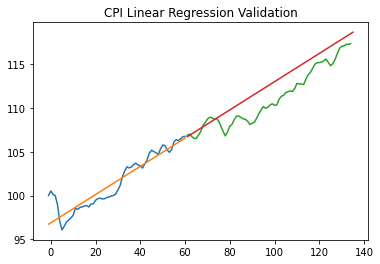

In [172]:
#Filter to values before September 2013
price_monthly_df_test = price_monthly_df[price_monthly_df['date'] >= '2013-09-01']

#Reindex the date to monthly periods 
#Reshape the data to numpy arrays for sklearn
X_test_cpi = ((price_monthly_df_test['date'].dt.year - 2008)*12 + price_monthly_df_test['date'].dt.month - 8).values.reshape(-1,1)
Y_test_cpi = price_monthly_df_test['CPI'].values.reshape(-1,1)

#Get the trend predictions for the validation test set
Y_valid_cpi = reg_cpi.predict(X_test_cpi)

#Plot both the training and test set trend
plt.title('CPI Linear Regression Validation')
plt.plot(X_train_cpi, Y_train_cpi)
plt.plot(X_train_cpi, Y_predict_cpi)
plt.plot(X_test_cpi, Y_test_cpi)
plt.plot(X_test_cpi, Y_valid_cpi)

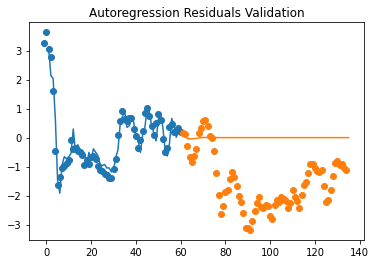

In [185]:
#Get the trend test residuals
Residuals_cpi_test = Y_test_cpi - Y_valid_cpi

#Get the autoregression predictions
Y_test_autoreg = auto_reg_detrend.predict(start=62, end=136).reshape(-1,1)

#Plot the train and test set residuals
plt.title("Autoregression Residuals Validation")
plt.scatter(X_train_cpi, Residuals_cpi)
plt.plot(X_train_cpi[2:], Y_train_autoreg)
plt.scatter(X_test_cpi, Residuals_cpi_test)
plt.plot(X_test_cpi, Y_test_autoreg)

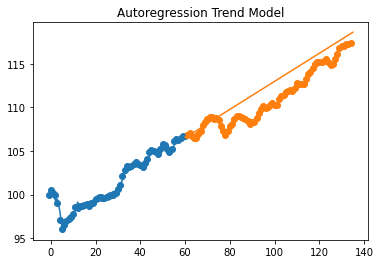

In [187]:
Y_test_ART = Y_test_autoreg + Y_valid_cpi


plt.title("Autoregression Trend Model Validation")
plt.scatter(X_train_cpi, Y_train_cpi)
plt.plot(X_train_cpi[2:], Y_train_ART)
plt.scatter(X_test_cpi, Y_test_cpi)
plt.plot(X_test_cpi, Y_test_ART)